In [1]:
%matplotlib inline
import pandas as pd
import librosa as lib
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import scipy
import os
from sklearn.preprocessing import StandardScaler

In [2]:
#import motion dataframe of only participant 1
motion1 = pd.read_pickle('DFs/Participant_Motion/PID_motion_1.pkl')

Reminder of what each look like

In [3]:
motion1.head(), motion1.shape

(         X         Y         Z  PID
 0  159.596  1845.594  1732.156    1
 1  159.583  1845.451  1732.144    1
 2  159.584  1845.308  1732.126    1
 3  159.587  1845.180  1732.105    1
 4  159.597  1845.072  1732.103    1,
 (36001, 4))

In [4]:
motion1.describe()

,X,Y,Z,PID
count,36001.000000,36001.000000,36001.000000,36001.0
mean,160.456958,1860.184987,1724.088614,1.0
std,4.317600,11.164595,6.404407,0.0
min,144.325000,1829.400000,1715.278000,1.0
25%,158.102000,1852.813000,1718.380000,1.0
50%,161.018000,1859.077000,1721.902000,1.0
75%,163.689000,1866.659000,1732.118000,1.0
max,170.325000,1901.478000,1733.874000,1.0


We need to create a time index to allow for resampling. THis will allow us to reduce our rows and therefore our compute time while also simplifying our sync up to the music data.

In [5]:
#Create datetime index
time = pd.date_range(start='00:00', freq='10L', periods=36001)
time.dtype

dtype('<M8[ns]')

In [6]:
#Reformat the index to minutes and decimal seconds
time = time.strftime('%M:%S.%f')
time.dtype

dtype('O')

In [7]:
#set datetime index
motiont = motion1.set_index(time)

In [8]:
motiont.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36001 entries, 00:00.000000 to 06:00.000000
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       36001 non-null  float64
 1   Y       36001 non-null  float64
 2   Z       36001 non-null  float64
 3   PID     36001 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 1.4+ MB


It appears that reformatting cause the index to lose it's datetime type, we will reset it

In [9]:
motiont.index = pd.to_datetime(motiont.index, format='%M:%S.%f')

In [10]:
motiont.shape

(36001, 4)

In [11]:
motiont

,X,Y,Z,PID
1900-01-01 00:00:00.000,159.596,1845.594,1732.156,1
1900-01-01 00:00:00.010,159.583,1845.451,1732.144,1
1900-01-01 00:00:00.020,159.584,1845.308,1732.126,1
1900-01-01 00:00:00.030,159.587,1845.180,1732.105,1
1900-01-01 00:00:00.040,159.597,1845.072,1732.103,1
...,...,...,...,...
1900-01-01 00:05:59.960,160.090,1837.312,1715.629,1
1900-01-01 00:05:59.970,160.122,1837.488,1715.619,1
1900-01-01 00:05:59.980,160.128,1837.653,1715.597,1
1900-01-01 00:05:59.990,160.147,1837.829,1715.599,1


Now that we have a datetime index, we can resample to 1 tenth of second or 100 milliseconds. We could choose a different value, but this is a good balance between reduce the size of the data for computation reasons as well as keeping enough data to be useful. We will use average values, which will also help with smoothing out some of the noise.

In [12]:
#set the music dataframe index to a time series and upsamplt to match the 100 readings per second from the motion data
motionr = motiont.resample('100L').mean()

In [13]:
def Import_Participant_Motion(par_list):
    #import each participant motion data from the file, add datetime index and resample to 2 tenths of a second
    #output dictionary of dataframes of motion
    output = {}
    time = pd.date_range(start='00:00', freq='10L', periods=35601)
    time = time.strftime('%M:%S.%f')
    for participant in par_list:
        motiont = pd.read_pickle('DFs/Participant_Motion/' + participant)
        motiont = motiont.iloc[:35601].set_index(time)
        motiont.index = pd.to_datetime(motiont.index, format='%M:%S.%f')
        motionr = motiont.resample('100L').mean()
        motionr = motionr.reset_index()
        motionr.rename({'index':'time'}, axis=1)
        output[participant[:-4]] = motionr
    return output

There is some variation for the total length of motion data across the participants. We have limited the data to the smallest value which cuts off the last 4 seconds of the recordings so as to prevent bias by using data at the end of the song that is only from a limited section of participants

In [14]:
#Create a list of participants motion files
par_motion_list = os.listdir('DFs/Participant_Motion')
#Import all motion files into a dictionary of dataframes
motion_dict = Import_Participant_Motion(par_motion_list)

In [15]:
#Take a look at one of the dataframes
motion_dict['PID_motion_12']

,index,X,Y,Z,PID
0,1900-01-01 00:00:00.000,2489.5332,1822.9520,1787.9955,12
1,1900-01-01 00:00:00.100,2489.9921,1822.1970,1788.0044,12
2,1900-01-01 00:00:00.200,2490.5049,1821.6897,1788.0098,12
3,1900-01-01 00:00:00.300,2490.9199,1821.0685,1788.0295,12
4,1900-01-01 00:00:00.400,2491.2135,1820.2560,1788.0830,12
...,...,...,...,...,...
3556,1900-01-01 00:05:55.600,2481.7291,1826.2237,1787.2313,12
3557,1900-01-01 00:05:55.700,2481.7019,1825.9336,1787.2227,12
3558,1900-01-01 00:05:55.800,2481.7115,1825.5014,1787.2282,12
3559,1900-01-01 00:05:55.900,2482.0292,1824.9666,1787.2624,12


We will now add some features that we can use for our model. We are going to predict the absolute value sum of euclidean motion (combination of all 3 directions) 1 second into the future. We will be saying the participant will move X mm in the next 1 second based on how they have moved in the previous time periods. The features we are creating will be made up of these past time periods and the features will be information about the time periods (min motion, max motion, average motion, etc.) that we can use to descrive what happened during that time period. These features use data from the individual participants so it is simpler to create them prior to joining all of the data together.

- *_disp - absololute value of displacement per step in noted direction
- *_disp_total - sum of disp from start in noted direction
- step_eucl - Euclidean distance moved in time step (combination of motion in all directions)
- total_eucl - Total Euclidean distance move since start (combination of motion in all directions)
- target_1_sec - Target for prediction, sum of motion for 1 second into the future using euclidean distance
- _*sec_hist_*_ - description of 1 second starting at time noted using function noted
        - Ex. _4sec_hist_mean_ - The mean motion in a tenth of a second during the time period from 4 seconds previous to 5 seconds previous 

We will backfill and forward fill over Nan values to prevent model errors. 

In [16]:
def create_lags(lags, step_df):
    #Creates columns of lag that shift back in increments of 1 second. This gives us seperate columns for 1, 2, 3, etc. seconds 
    #into the past that we can use to create descriptions of those time periods using functions
    base = step_df.copy()
    for rows in lags:
        lag = step_df.shift(periods=rows*10) #10 rows equals 1 second
        lag.rename(columns={'step_eucl':'step_eucl_{sec}sec_hist'.format(sec=rows)}, inplace=True)
        base = pd.concat([base, lag], axis=1)
    return base

In [17]:
def create_lags_small(lags, step_df):
    #Creates columns of lag that shift back in increments of 0.1 second. This gives us seperate columns for 1, 2, 3, etc. seconds 
    #into the past that we can use to create descriptions of those time periods using functions
    base = step_df.copy()
    for rows in lags:
        lag = step_df.shift(periods=rows) #10 rows equals 1 second
        lag.rename(columns={'step_eucl':'step_eucl_{sec}sec_hist'.format(sec=rows/10)}, inplace=True)
        base = pd.concat([base, lag], axis=1)
    return base

In [18]:
def aggregate_lags(aggs, history):
    #Creates new columns using aggregating functions for each of the new past time columns created by create_lags function
    history_aggregation = history.copy()
    for func in aggs:#.keys():
        for col in history.columns:
            if col != 'step_eucl':
                history_aggregation['_{num}sec_hist_{func}_'.format(num=col[10:13], func=func),] = history[col].diff().rolling(5).agg(func)
     
    return history_aggregation

In [19]:
#Creating features do be used in the model later. Indivdualized for each PID
for key in motion_dict.keys():
    
    #Absolute Value of step displacement every 0.1 seconds (every row)
    motion_dict[key]['X_disp'] = abs(motion_dict[key]['X'].diff())
    motion_dict[key]['Y_disp'] = abs(motion_dict[key]['Y'].diff())
    motion_dict[key]['Z_disp'] = abs(motion_dict[key]['Z'].diff())
    
    #Total displacement from start to time in row
    motion_dict[key]['X_disp_total'] = motion_dict[key]['X_disp'].cumsum()
    motion_dict[key]['Y_disp_total'] = motion_dict[key]['Y_disp'].cumsum()
    motion_dict[key]['Z_disp_total'] = motion_dict[key]['Z_disp'].cumsum()
    
    #Step Euclidean Distance every 0.2 seconds (every row)
    motion_dict[key]['step_eucl'] = np.sqrt(motion_dict[key]['X_disp']**2 + motion_dict[key]['Y_disp']**2 + motion_dict[key]['Z_disp']**2)
   
    #Total Euclidean Distance from start to time in row
    motion_dict[key]['total_eucl'] = np.sqrt(motion_dict[key]['X_disp_total']**2 + motion_dict[key]['Y_disp_total']**2 + motion_dict[key]['Z_disp_total']**2)
    
    
    #Target variables - sum of euclidean distance traveled over 1 second in the future
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=10, min_periods=10)
    motion_dict[key]['target_1_sec'] = motion_dict[key]['step_eucl'].rolling(window=indexer).sum()

    #Variable that looks at sum of motion looking back 1 second. This can be used to confirm target column is computed correctly
    motion_dict[key]['step_eucl_1s_sum_back'] = motion_dict[key]['step_eucl'].rolling(10, min_periods=10).sum()
    
    #set up amount of time to look back X lag 1 means time periods is 1 seconds to 2 seconds, lag 10 means 10 seconds to 11 seconds
    lags= range(1, 11)
    hist = create_lags(lags, motion_dict[key][['step_eucl']])
    
    #create columns for each time period with aggregating functions
    agg_funcs = ['mean', 'max', 'min', 'std']
    hist_agg = aggregate_lags(agg_funcs, hist)
    
    #Combine the participants data frame with the aggregated information
    motion_dict[key] = pd.concat([motion_dict[key], hist_agg.drop(columns='step_eucl')], axis=1)
    
    #set up amount of time to look back X lag_small 1 means time periods is 0.1 seconds to 1.1 seconds, lag 10 means 10.1 seconds to 11.1 seconds
    lags2= range(1, 11)
    hist2 = create_lags_small(lags2, motion_dict[key][['step_eucl']])
    
    #create columns for each time period with aggregating functions
    agg_funcs2 = ['mean', 'max', 'min', 'std']
    hist_agg2 = aggregate_lags(agg_funcs2, hist2)
    
    #Combine the participants data frame with the aggregated information
    motion_dict[key] = pd.concat([motion_dict[key], hist_agg2.drop(columns='step_eucl')], axis=1)
    
    #fill Nan values backward and forward (expect values to only be where rolling functions run out of windows aka beginnnig and end)
    motion_dict[key].bfill(inplace=True)
    motion_dict[key].ffill(inplace=True)

In [20]:
#look at an example dataframe with the new columns
motion_dict['PID_motion_14']

,index,X,Y,Z,PID,X_disp,Y_disp,Z_disp,X_disp_total,Y_disp_total,...,"(_0.1sec_hist_std_,)","(_0.2sec_hist_std_,)","(_0.3sec_hist_std_,)","(_0.4sec_hist_std_,)","(_0.5sec_hist_std_,)","(_0.6sec_hist_std_,)","(_0.7sec_hist_std_,)","(_0.8sec_hist_std_,)","(_0.9sec_hist_std_,)","(_1.0sec_hist_std_,)"
0,1900-01-01 00:00:00.000,863.0060,957.9319,1796.2854,14,0.0260,1.1200,0.0345,0.0260,1.1200,...,0.194032,0.194032,0.194032,0.194032,0.194032,0.194032,0.194032,0.194032,0.194032,0.194032
1,1900-01-01 00:00:00.100,862.9800,959.0519,1796.2509,14,0.0260,1.1200,0.0345,0.0260,1.1200,...,0.194032,0.194032,0.194032,0.194032,0.194032,0.194032,0.194032,0.194032,0.194032,0.194032
2,1900-01-01 00:00:00.200,862.9118,960.1253,1796.2946,14,0.0682,1.0734,0.0437,0.0942,2.1934,...,0.194032,0.194032,0.194032,0.194032,0.194032,0.194032,0.194032,0.194032,0.194032,0.194032
3,1900-01-01 00:00:00.300,862.5629,961.0420,1796.3974,14,0.3489,0.9167,0.1028,0.4431,3.1101,...,0.194032,0.194032,0.194032,0.194032,0.194032,0.194032,0.194032,0.194032,0.194032,0.194032
4,1900-01-01 00:00:00.400,862.0109,961.0291,1796.3724,14,0.5520,0.0129,0.0250,0.9951,3.1230,...,0.194032,0.194032,0.194032,0.194032,0.194032,0.194032,0.194032,0.194032,0.194032,0.194032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3556,1900-01-01 00:05:55.600,880.5607,966.3548,1794.9989,14,0.2132,1.0447,0.0271,716.0699,1733.9627,...,0.356418,0.424707,0.448736,0.569405,0.562818,0.573777,0.517535,0.447627,0.273216,0.278670
3557,1900-01-01 00:05:55.700,880.9466,966.9257,1794.9851,14,0.3859,0.5709,0.0138,716.4558,1734.5336,...,0.240492,0.356418,0.424707,0.448736,0.569405,0.562818,0.573777,0.517535,0.447627,0.273216
3558,1900-01-01 00:05:55.800,881.1937,967.6163,1794.9833,14,0.2471,0.6906,0.0018,716.7029,1735.2242,...,0.341292,0.240492,0.356418,0.424707,0.448736,0.569405,0.562818,0.573777,0.517535,0.447627
3559,1900-01-01 00:05:55.900,881.3452,968.3472,1795.0062,14,0.1515,0.7309,0.0229,716.8544,1735.9551,...,0.187410,0.341292,0.240492,0.356418,0.424707,0.448736,0.569405,0.562818,0.573777,0.517535


In [21]:
#create a single dataframe with all motion data that is resampled and includes features
motion_all = pd.concat([motion_dict[key] for key in motion_dict.keys()])
motion_all.sort_values(by=['index', 'PID']).reset_index(drop=True)

,index,X,Y,Z,PID,X_disp,Y_disp,Z_disp,X_disp_total,Y_disp_total,...,"(_0.1sec_hist_std_,)","(_0.2sec_hist_std_,)","(_0.3sec_hist_std_,)","(_0.4sec_hist_std_,)","(_0.5sec_hist_std_,)","(_0.6sec_hist_std_,)","(_0.7sec_hist_std_,)","(_0.8sec_hist_std_,)","(_0.9sec_hist_std_,)","(_1.0sec_hist_std_,)"
0,1900-01-01 00:00:00,159.6240,1845.0448,1732.1037,1,0.1470,0.6545,0.0167,0.1470,0.6545,...,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534
1,1900-01-01 00:00:00,927.2574,1928.7439,1696.3542,2,0.0295,0.2520,0.1070,0.0295,0.2520,...,0.395299,0.395299,0.395299,0.395299,0.395299,0.395299,0.395299,0.395299,0.395299,0.395299
2,1900-01-01 00:00:00,1738.0152,1892.0224,1640.8933,3,0.1185,0.2475,0.0035,0.1185,0.2475,...,0.307355,0.307355,0.307355,0.307355,0.307355,0.307355,0.307355,0.307355,0.307355,0.307355
3,1900-01-01 00:00:00,2546.7655,1799.1780,1745.7838,4,0.0519,0.4042,0.0065,0.0519,0.4042,...,0.266687,0.266687,0.266687,0.266687,0.266687,0.266687,0.266687,0.266687,0.266687,0.266687
4,1900-01-01 00:00:00,159.6430,244.5189,1644.6071,5,0.6382,0.2313,0.0465,0.6382,0.2313,...,0.486725,0.486725,0.486725,0.486725,0.486725,0.486725,0.486725,0.486725,0.486725,0.486725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259948,1900-01-01 00:05:56,1718.4800,1076.2740,1860.4970,70,0.0550,0.5498,0.0200,436.9239,1051.3340,...,0.391151,0.394231,0.162270,0.263645,0.261948,0.260867,0.276461,0.356533,0.395255,0.385827
259949,1900-01-01 00:05:56,2517.8410,1076.6340,1724.7950,71,0.0614,0.1203,0.0093,794.1966,1570.0365,...,0.293313,0.308360,0.300809,0.309599,0.303017,0.267159,0.257097,0.257804,0.141604,0.196831
259950,1900-01-01 00:05:56,21.7320,292.9990,1696.3110,72,0.0044,0.5012,0.0627,631.6395,1882.6469,...,0.219058,0.145182,0.127952,0.128621,0.136222,0.119768,0.122524,0.122280,0.117691,0.086006
259951,1900-01-01 00:05:56,870.4020,162.0640,1727.4780,73,0.2782,0.1388,0.0064,531.1476,1340.0535,...,0.261736,0.295187,0.303750,0.278844,0.214585,0.176668,0.097698,0.089642,0.067294,0.086694


In [22]:
#Add a millisecond column that counts milliseconds from start. An 'int' as opposed to datetime
motion_all['millisecond'] = (motion_all['index'].dt.microsecond + motion_all['index'].dt.second*1000000 + motion_all['index'].dt.minute*60*1000000)/1000
motion_all['millisecond'] = motion_all['millisecond'].astype('int')
motion_all

,index,X,Y,Z,PID,X_disp,Y_disp,Z_disp,X_disp_total,Y_disp_total,...,"(_0.2sec_hist_std_,)","(_0.3sec_hist_std_,)","(_0.4sec_hist_std_,)","(_0.5sec_hist_std_,)","(_0.6sec_hist_std_,)","(_0.7sec_hist_std_,)","(_0.8sec_hist_std_,)","(_0.9sec_hist_std_,)","(_1.0sec_hist_std_,)",millisecond
0,1900-01-01 00:00:00.000,159.6240,1845.0448,1732.1037,1,0.1470,0.6545,0.0167,0.1470,0.6545,...,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,0
1,1900-01-01 00:00:00.100,159.7710,1844.3903,1732.0870,1,0.1470,0.6545,0.0167,0.1470,0.6545,...,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,100
2,1900-01-01 00:00:00.200,160.0116,1844.3733,1732.0775,1,0.2406,0.0170,0.0095,0.3876,0.6715,...,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,200
3,1900-01-01 00:00:00.300,160.4118,1844.8992,1732.0579,1,0.4002,0.5259,0.0196,0.7878,1.1974,...,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,300
4,1900-01-01 00:00:00.400,160.4588,1846.0076,1732.0856,1,0.0470,1.1084,0.0277,0.8348,2.3058,...,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3556,1900-01-01 00:05:55.600,102.3330,1996.0739,1804.8869,9,0.0750,0.2230,0.0235,842.2796,1696.3910,...,0.265657,0.311178,0.330454,0.299413,0.328395,0.357403,0.352065,0.320936,0.340562,355600
3557,1900-01-01 00:05:55.700,102.7594,1995.9276,1804.9091,9,0.4264,0.1463,0.0222,842.7060,1696.5373,...,0.246003,0.265657,0.311178,0.330454,0.299413,0.328395,0.357403,0.352065,0.320936,355700
3558,1900-01-01 00:05:55.800,102.8787,1995.5776,1804.9454,9,0.1193,0.3500,0.0363,842.8253,1696.8873,...,0.315069,0.246003,0.265657,0.311178,0.330454,0.299413,0.328395,0.357403,0.352065,355800
3559,1900-01-01 00:05:55.900,102.7263,1995.0575,1804.9707,9,0.1524,0.5201,0.0253,842.9777,1697.4074,...,0.280275,0.315069,0.246003,0.265657,0.311178,0.330454,0.299413,0.328395,0.357403,355900


In [23]:
def add_segment(df, col='millisecond'):
    #adds segment of music label to dataset based on millisecond column being present
    df['segment'] = 'silence'
    df.loc[motion_all[col].between(180000, 200000), 'segment'] = 'class1'
    df.loc[motion_all[col].between(200000, 215000), 'segment'] = 'class2'
    df.loc[motion_all[col].between(215000, 255000), 'segment'] = 'class3'
    df.loc[motion_all[col].between(255000, 275000), 'segment'] = 'class4'
    df.loc[motion_all[col].between(275000, 310000), 'segment'] = 'hiphop'
    df.loc[motion_all[col].between(310000, 330000), 'segment'] = 'salsa'
    df.loc[motion_all[col].between(330000, 356000), 'segment'] = 'edm'

Now that we have a single set to work with lets take a look at some of the average movements compared to the music

In [24]:
#Add segment column to dataframe, can be used to look at different data based on segments
add_segment(motion_all)
motion_all

,index,X,Y,Z,PID,X_disp,Y_disp,Z_disp,X_disp_total,Y_disp_total,...,"(_0.3sec_hist_std_,)","(_0.4sec_hist_std_,)","(_0.5sec_hist_std_,)","(_0.6sec_hist_std_,)","(_0.7sec_hist_std_,)","(_0.8sec_hist_std_,)","(_0.9sec_hist_std_,)","(_1.0sec_hist_std_,)",millisecond,segment
0,1900-01-01 00:00:00.000,159.6240,1845.0448,1732.1037,1,0.1470,0.6545,0.0167,0.1470,0.6545,...,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,0,silence
1,1900-01-01 00:00:00.100,159.7710,1844.3903,1732.0870,1,0.1470,0.6545,0.0167,0.1470,0.6545,...,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,100,silence
2,1900-01-01 00:00:00.200,160.0116,1844.3733,1732.0775,1,0.2406,0.0170,0.0095,0.3876,0.6715,...,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,200,silence
3,1900-01-01 00:00:00.300,160.4118,1844.8992,1732.0579,1,0.4002,0.5259,0.0196,0.7878,1.1974,...,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,300,silence
4,1900-01-01 00:00:00.400,160.4588,1846.0076,1732.0856,1,0.0470,1.1084,0.0277,0.8348,2.3058,...,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,0.402534,400,silence
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3556,1900-01-01 00:05:55.600,102.3330,1996.0739,1804.8869,9,0.0750,0.2230,0.0235,842.2796,1696.3910,...,0.311178,0.330454,0.299413,0.328395,0.357403,0.352065,0.320936,0.340562,355600,edm
3557,1900-01-01 00:05:55.700,102.7594,1995.9276,1804.9091,9,0.4264,0.1463,0.0222,842.7060,1696.5373,...,0.265657,0.311178,0.330454,0.299413,0.328395,0.357403,0.352065,0.320936,355700,edm
3558,1900-01-01 00:05:55.800,102.8787,1995.5776,1804.9454,9,0.1193,0.3500,0.0363,842.8253,1696.8873,...,0.246003,0.265657,0.311178,0.330454,0.299413,0.328395,0.357403,0.352065,355800,edm
3559,1900-01-01 00:05:55.900,102.7263,1995.0575,1804.9707,9,0.1524,0.5201,0.0253,842.9777,1697.4074,...,0.315069,0.246003,0.265657,0.311178,0.330454,0.299413,0.328395,0.357403,355900,edm


Let's take a look at the different values for all partipcants based on the segment they are listening to.

In [25]:
motion_all.groupby('segment').mean()[['X_disp', 'Y_disp', 'Z_disp', 'step_eucl']]

,X_disp,Y_disp,Z_disp,step_eucl
segment,,,,
class1,0.239044,0.461881,0.046582,0.570076
class2,0.253248,0.489957,0.052562,0.604920
class3,0.255440,0.493772,0.052657,0.609969
class4,0.256133,0.491188,0.049259,0.605907
edm,0.254904,0.496028,0.050623,0.611152
hiphop,0.255918,0.483409,0.052613,0.600895
salsa,0.255981,0.483527,0.053414,0.600442
silence,0.240128,0.476745,0.048960,0.584498


While there doesn't seem to be consistent differences for the different segments, they music segment averages nearly all exceed the silence segment for amount of motion

Let's take a quick look at the average movement of the partiicpants over time

In [26]:
mean_motion = motion_all.groupby('index').mean()

In [27]:
mean_motion.drop(columns='PID', inplace=True)

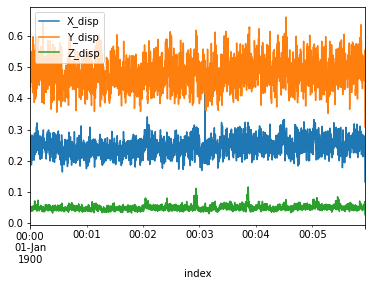

In [28]:
mean_motion[['X_disp', 'Y_disp', 'Z_disp']].plot()
plt.show()

It appears that thre is generally more motion in the Y direction then any others. Next comes X and Z follows. I believe that the Y dimension represents forward/backward while the X represents side to side. It makes sense that Z would have the least motion as it is much easier to prevent yourself from bouncing up and down than it is swaying side to side. The Z motion is likely all due to the head moving downward as it moves away from directly over the center of gravity (leaning over) and back up as it returns (standing up straight)

Let's confirm that the target variable is calulated as we expect. They should be equal to the a rolling sum shifted back 1 second, so we should when the sum in the future second is plotted with the sum for the past second they should look the same just with a 1 second shift.

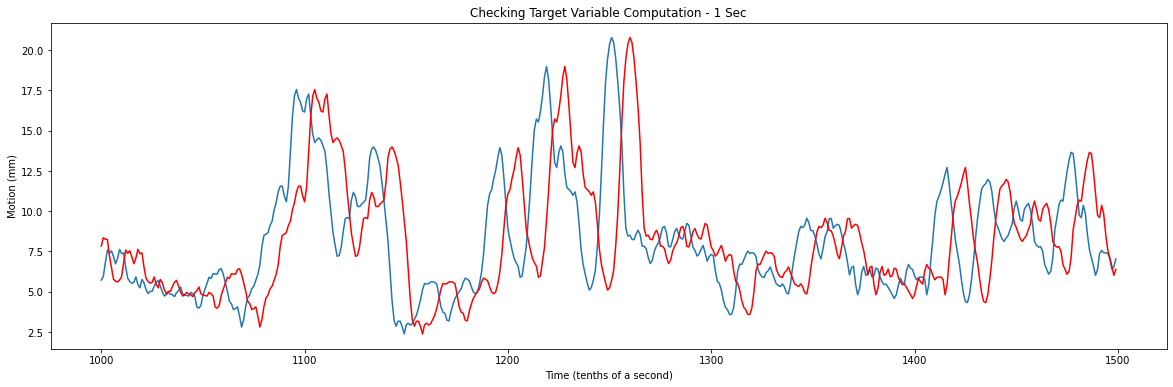

In [29]:
PID_1 = motion_all[motion_all['PID']==1]
PID_1['target_1_sec'][1000:1500].plot(figsize=(20, 6))
PID_1['step_eucl_1s_sum_back'][1000:1500].plot(color='red', figsize=(20, 6))
plt.title('Checking Target Variable Computation - 1 Sec')
plt.ylabel('Motion (mm)')
plt.xlabel('Time (tenths of a second)')
plt.show()

The graph is as we expected, but let's take a closer look to confirm it is a 1 second shift

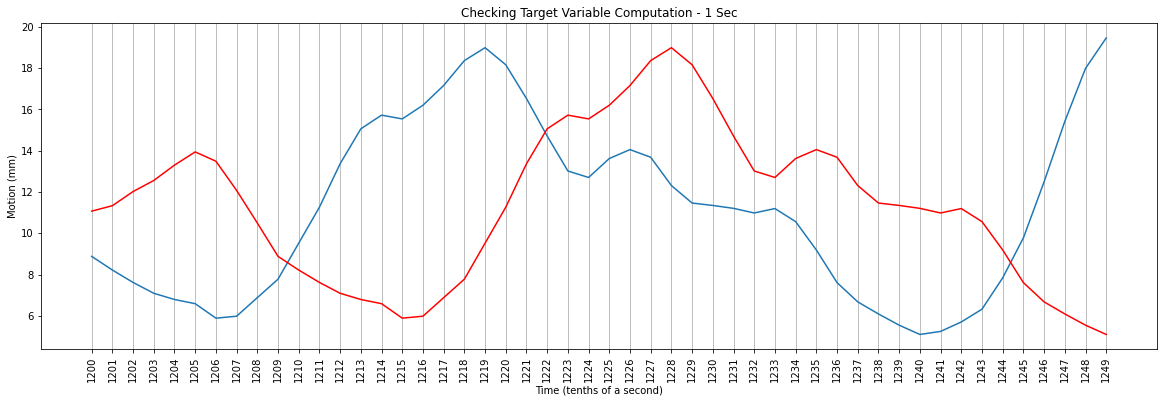

In [30]:
PID_1 = motion_all[motion_all['PID']==1]
PID_1['target_1_sec'][1200:1250].plot(figsize=(20, 6))
PID_1['step_eucl_1s_sum_back'][1200:1250].plot(color='red', figsize=(20, 6))
plt.xticks(range(1200,1250), rotation=90)
plt.grid(axis='x')
plt.title('Checking Target Variable Computation - 1 Sec')
plt.ylabel('Motion (mm)')
plt.xlabel('Time (tenths of a second)')
plt.show()

We can see using the gridlines that the red and blue curves are seperated by 10 gridlines that represent 10 tenths of a second or 1 second

Looking at the above grpahs we can confirm that the target variables are calulated as expected.

In [31]:
motion_all.to_pickle('DFs/motion_all.pkl')